Imports

In [1]:
# Configuration files
import io
from pathlib import Path
import requests
import json
import re
import os
from PIL import Image
from dotenv import load_dotenv
from openai import OpenAI
import replicate
from IPython.display import display

Functions

In [2]:
# Utilities
def add_white_background(image_path: Path) -> io.BytesIO:
    try:
        with Image.open(image_path) as img:
            if img.mode in ('RGBA', 'LA') or (img.mode == 'P' and 'transparency' in img.info):
                bg = Image.new('RGB', img.size, (255, 255, 255))
                mask = img.split()[-1] if 'A' in img.getbands() else None
                bg.paste(img, mask=mask)
                buffer = io.BytesIO()
                bg.save(buffer, format='PNG')
            else:
                buffer = io.BytesIO()
                img.save(buffer, format='PNG')
        buffer.seek(0)
        return buffer
    except Exception as e:
        print(f"Failed to process image background: {e}")
        with open(image_path, "rb") as f:
            return io.BytesIO(f.read())

def get_model_image() -> Path:
    candidates = list(MODEL_INPUT_DIR.glob("*.[pj][pn]g")) + list(MODEL_INPUT_DIR.glob("*.webp"))
    if candidates:
        return candidates[0]
    raise FileNotFoundError("No model image found in 'model_input/' folder.")

# Category Mapping
CATEGORY_MAPPING = {
    "Dresses": "dresses", "Gowns": "dresses", "Dress": "dresses",
    "Tops": "upper_body", "Top": "upper_body", "Blouses": "upper_body", "Blouse": "upper_body", "Shirts": "upper_body", "Shirt": "upper_body",
    "Jumpers": "upper_body", "Jumper": "upper_body", "Jackets": "upper_body", "Jacket": "upper_body", "Coats": "upper_body", "Coat": "upper_body",
    "Sweaters": "upper_body", "Sweater": "upper_body", "Outerwear": "upper_body", "Hoodies": "upper_body", "Hoodie": "upper_body",
    "Cardigans": "upper_body", "Cardigan": "upper_body",
    "Jeans": "lower_body", "Jean": "lower_body", "Skirts": "lower_body", "Skirt": "lower_body", "Pants": "lower_body", "Pant": "lower_body",
    "Trousers": "lower_body", "Trouser": "lower_body", "Shorts": "lower_body", "Short": "lower_body", "Bottoms": "lower_body",
    "T-Shirts": "upper_body", "T-Shirt": "upper_body", "Polos": "upper_body", "Polo": "upper_body", "Sweatshirts": "upper_body", "Sweatshirt": "upper_body",
    "Shirts (Men)": "upper_body", "Blazers": "upper_body", "Blazer": "upper_body", "Coats (Men)": "upper_body",
    "Jackets (Men)": "upper_body", "Hoodies (Men)": "upper_body", "Sweaters (Men)": "upper_body",
    "Jeans (Men)": "lower_body", "Chinos": "lower_body", "Chino": "lower_body", "Shorts (Men)": "lower_body",
    "Trousers (Men)": "lower_body", "Cargo Pants": "lower_body",
    "Bags": None, "Shoes": None, "Sandals": None, "Boots": None,
    "Hats": None, "Caps": None, "Socks": None,
    "Bracelets": None, "Earrings": None, "Necklaces": None, "Rings": None,
    "Scarves": None, "Belts": None, "Gloves": None,
}

In [3]:
# Analyze outfit using GPT Vision
def analyze_outfit(image_path: Path) -> dict:
    try:
        with open(image_path, "rb") as f:
            img_base64 = f.read()
            
        valid_categories = [cat for cat in CATEGORY_MAPPING.keys() if CATEGORY_MAPPING[cat] is not None]
        categories_str = ", ".join(valid_categories)
        
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system",
                 "content": (
                     f"You are a fashion AI. Given an outfit image, return ONLY a single JSON object with keys: product_name, category, description. "
                     f"The category MUST be one of these exact values: {categories_str}. "
                     f"Skip accessories like hats, shoes, scarves, bags, jewelry. "
                     f"Return only ONE item (the main clothing piece). Do not return an array or multiple objects."
                 )},
                {"role": "user",
                 "content": [
                     {"type": "text", "text": "Return ONLY a single JSON object describing the main clothing item in this image. The category must match the allowed list."},
                     {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{__import__('base64').b64encode(img_base64).decode()}"}}
                 ]}
            ],
            temperature=0
        )

        raw_text = response.choices[0].message.content.strip()
        print(f"\nGPT output for {image_path.name}:\n{raw_text}\n")
        
        # Extract first JSON object only
        match = re.search(r"\{[^{}]*\}", raw_text)
        if not match:
            print(f"No valid JSON found in response for {image_path.name}")
            return None
        
        json_str = match.group(0)
        result = json.loads(json_str)
        print(f"Parsed: {result}")
        return result
    except json.JSONDecodeError as e:
        print(f"JSON parsing error for {image_path.name}: {e}")
        return None
    except Exception as e:
        print(f"Failed to analyze {image_path.name}: {e}")
        return None

In [4]:
# Run VTON pipeline
def run_vton():
    outfit_files = list(OUTFIT_DIR.glob("*.[pj][pn]g")) + list(OUTFIT_DIR.glob("*.webp"))
    if not outfit_files:
        raise FileNotFoundError("No outfit images found in 'outfit_tryon/' folder.")

    current_image = MODEL_IMAGE_PATH
    final_image_data = None

    for idx, outfit in enumerate(outfit_files, start=1):
        print(f"\nProcessing outfit {idx}/{len(outfit_files)}: {outfit.name}")

        info = analyze_outfit(outfit)
        if not info:
            continue

        raw_cat = info.get("category", "").strip()
        mapped_cat = CATEGORY_MAPPING.get(raw_cat)
        if not mapped_cat:
            print(f"Skipping {outfit.name}: category '{raw_cat}' not allowed")
            continue

        description = info.get("description", f"A stylish {mapped_cat.replace('_',' ')} garment")
        outfit_processed = add_white_background(outfit)

        try:
            with open(current_image, "rb") as human_file:
                result = replicate.run(
                    "cuuupid/idm-vton:0513734a452173b8173e907e3a59d19a36266e55b48528559432bd21c7d7e985",
                    input={
                        "crop": False,
                        "seed": 42,
                        "steps": 30,
                        "category": mapped_cat,
                        "force_dc": False,
                        "garm_img": outfit_processed,
                        "human_img": human_file,
                        "mask_only": False,
                        "garment_des": description
                    }
                )
            img_url = result[0] if isinstance(result, list) else result
            final_image_data = requests.get(img_url).content
        except Exception as e:
            print(f"Replicate model failed: {e}")
            continue

    if final_image_data:
        with open(FINAL_OUTPUT, "wb") as f:
            f.write(final_image_data)
        print(f"\nFinal output saved: {FINAL_OUTPUT}")
        display(Image.open(FINAL_OUTPUT))
    else:
        print("No output generated. Check your inputs and API keys.")

Virtual Try-On Directories and Model Initialization

In [5]:
# Load environment variables
ROOT_DIR = Path('.')
ENV_PATH = ROOT_DIR.parent / ".env"
load_dotenv(dotenv_path=ENV_PATH)

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
REPLICATE_API_TOKEN = os.getenv("REPLICATE_API_TOKEN")

if not OPENAI_API_KEY or not REPLICATE_API_TOKEN:
    raise ValueError("Please set OPENAI_API_KEY and REPLICATE_API_TOKEN in your .env file")

os.environ["REPLICATE_API_TOKEN"] = REPLICATE_API_TOKEN
client = OpenAI(api_key=OPENAI_API_KEY)

In [10]:
# Paths
MODEL_INPUT_DIR = ROOT_DIR / "model_input"
OUTFIT_DIR = ROOT_DIR / "outfit_tryon"
OUTPUT_DIR = ROOT_DIR / "virtual_tryon_output"
FINAL_OUTPUT = OUTPUT_DIR / "final_tryon.png"

MODEL_INPUT_DIR.mkdir(parents=True, exist_ok=True)
OUTFIT_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

In [11]:
# Get model image path
MODEL_IMAGE_PATH = get_model_image()
print(f"Using model image: {MODEL_IMAGE_PATH}")

Using model image: model_input/model.jpg



Processing outfit 1/1: sweatshirt.webp

GPT output for sweatshirt.webp:
{
    "product_name": "Plain and Simple Sweatshirt",
    "category": "Sweatshirts",
    "description": "A casual grey sweatshirt with a minimalist design and 'Plain and Simple' text on the front."
}

Parsed: {'product_name': 'Plain and Simple Sweatshirt', 'category': 'Sweatshirts', 'description': "A casual grey sweatshirt with a minimalist design and 'Plain and Simple' text on the front."}

Final output saved: virtual_tryon_output/final_tryon.png


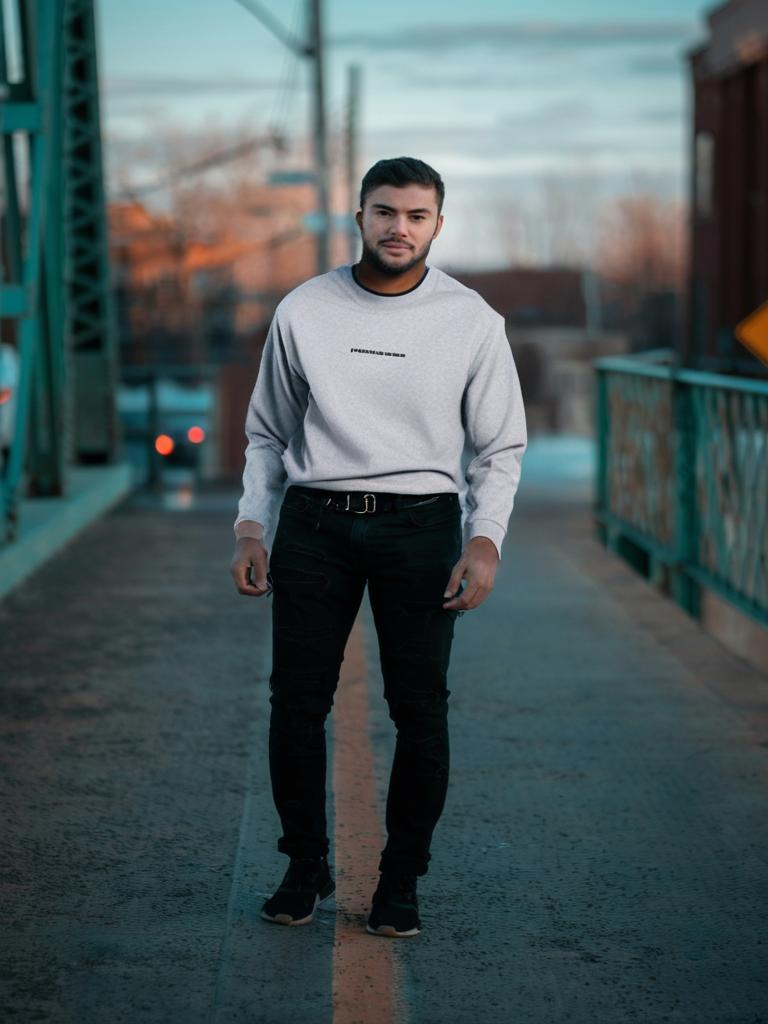

In [12]:
# Run
run_vton()